In [1]:
import torch
from lmnav.config.default import get_config
from hydra.utils import instantiate
from lmnav.common.writer import *

from lmnav.dataset.datasets import OfflineEpisodeDataset
from lmnav.models.base_policy import instantiate_model
from tqdm import tqdm
import os
from collections import defaultdict
from scipy.interpolate import interp1d
from dtw import dtw
from matplotlib import pyplot as plt


import numpy as np


def euclidean_dist(a, b):
    return np.linalg.norm(np.array(a) - np.array(b), ord=2)


def interpolate_point_pair(v1, v2, t):
    """
    interpolate between two points

    Args:
        v1: point 1
        v2: point 2
        t: parameterized variable

    Returns:

    """
    return tuple((1 - t) * x1 + t * x2 for x1, x2 in zip(v1, v2))


def resample_trajectory(points, num_samples):
    """
    Resample a set of points along a trajectory.

    :param points: A 2D numpy array of shape [N, 2], representing (x, y) coordinates.
    :param num_samples: The number of points to resample along the trajectory.
    :return: A 2D numpy array of resampled points.
    """
    # Extract x and y coordinates
    x = points[:, 0]
    y = points[:, 1]

    # Compute the cumulative distance along the trajectory
    distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    cumulative_distance = np.insert(np.cumsum(distances), 0, 0)

    # Create a linear interpolator for each coordinate
    interpolator_x = interp1d(cumulative_distance, x, kind='linear')
    interpolator_y = interp1d(cumulative_distance, y, kind='linear')

    # Generate equally spaced distances along the trajectory
    distance_samples = np.linspace(0, cumulative_distance[-1], num_samples)

    # Resample points
    resampled_x = interpolator_x(distance_samples)
    resampled_y = interpolator_y(distance_samples)

    return np.vstack((resampled_x, resampled_y)).T

def compute_ndtw(query, ref, success_dist, return_dtw=False):
    """
    computes normalized dynamic time warping metric
    Args:
        query:
        ref:
        success_dist:

    Returns:

    """
    dtw_dist, cost_matrix, acc_cost_matrix, path = dtw(query, ref, dist=euclidean_dist)

    nDTW = np.exp(-(dtw_dist / (len(ref) * success_dist)))

    if return_dtw:
        return nDTW, dtw_dist

    return nDTW

def plot_multiple_trajectories(trajectories):
    """
    Plot multiple trajectories on a single plot.

    :param trajectories: A list of 2D numpy arrays, each representing a trajectory.
    """
    plt.figure(figsize=(10, 6))

    for i, trajectory in enumerate(trajectories):
        plt.plot(trajectory[:, 0], trajectory[:, 1], 'o-', label=f'Trajectory {i+1}')

    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.title('Multiple Trajectories')
    plt.legend()
    plt.grid(True)
    plt.show()

/coc/testnvme/pputta7/mambaforge/envs/lmnav/lib/python3.9/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


[2024-01-24 12:04:41,241] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [13]:
path = "/srv/flash1/pputta7/projects/lm-nav/data/datasets/lmnav/offline_1env_karmesh+clip"
data = []
for item in tqdm(os.listdir(path)):
    data.append(torch.load(os.path.join(path, item)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35608/35608 [07:50<00:00, 75.62it/s]


In [12]:
all(['room_labels' in item for item in data])

True

In [3]:
mapping = defaultdict(lambda: [].copy())
for item in data:
    mapping[item['episode_id']].append(item)

In [4]:
histogram = {key: len(v) for key, v in mapping.items() if len(v) > 3}
len(histogram.keys())

8874

In [5]:
delta[0]

NameError: name 'delta' is not defined

In [8]:
common_rooms_deltas = defaultdict(lambda: 0)
for _id, episodes in mapping.items():
    # can i make a pair
    path_diffs = []
    for a in episodes:
        for b in episodes:
            path_diffs.append(set(a['room_labels']).symmetric_difference(b['room_labels']))

    for rooms in path_diffs:
        for room in list(rooms):
            common_rooms_deltas[room] += 1

KeyError: 'room_labels'

In [21]:
instruction_tuning_data = []

for _id, episodes in mapping.items():
    for i, a in enumerate(episodes):
        for j, b in enumerate(episodes[i:]):
            diff = set(a['room_labels']).symmetric_difference(set(b['room_labels']))
            if 'laundry room' in diff:
                instruction = "{Visit/Don't Visit} the laundry room"
                instruction_tuning_data.append((instruction, a, b))

In [26]:
instruction_tuning_data[0][1]['room_labels']
instruction_tuning_data[0][2]['room_labels']

['office room', 'hallway', 'living room', 'hallway', 'office room']

In [40]:
num_points = 50
# trajectories = [torch.tensor(item['coords']) for item in mapping[6472]]
idx = 1
trajectories = [torch.tensor(instruction_tuning_data[idx][t]['coords'])[:, [0, 2]] for t in (1, 2)]
room_labels = [instruction_tuning_data[idx][t]['room_labels'] for t in (1, 2)]
resampled_trajectories = [resample_trajectory(t, num_points) for t in trajectories]
dist_matrix = torch.zeros(len(resampled_trajectories), len(resampled_trajectories))
for i, x in enumerate(resampled_trajectories):
    for j, y in enumerate(resampled_trajectories):
        dist_matrix[i][j] = compute_ndtw(x, y, 1.0)

dist_matrix

tensor([[nan, nan],
        [nan, nan]])

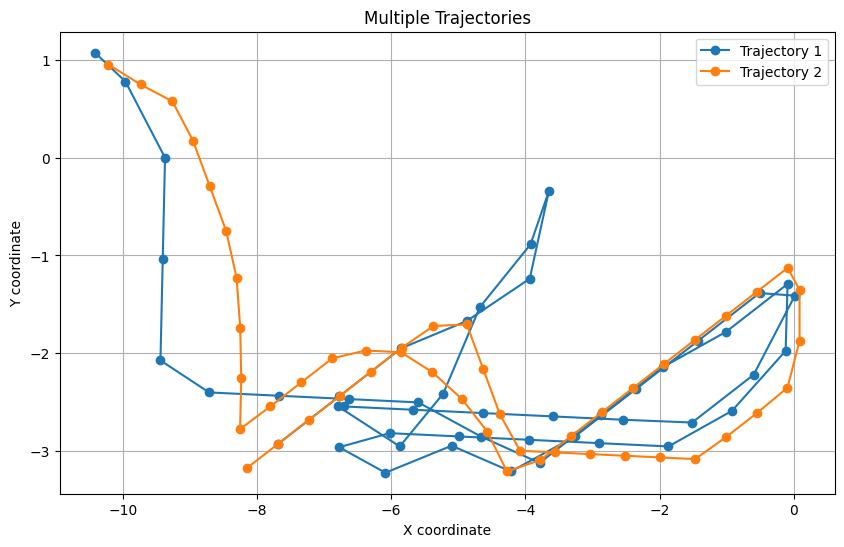

In [42]:
plot_multiple_trajectories(resampled_trajectories)

In [33]:
room_labels

[['office room',
  'hallway',
  'living room',
  'hallway',
  'living room',
  'hallway',
  'laundry room',
  'hallway',
  'living room',
  'hallway',
  'office room'],
 ['office room', 'hallway', 'living room', 'hallway', 'office room']]